## Assignment 4 Classification

## Conceptual

1. Discuss the differences between LDA and QDA in terms of their main assumptions
about classes, decision boundaries, number of samples, and overfitting.
- LDA and QDA are classification methods that model each class as coming from a multivariate Normal distribution; however, they differ in how "flexible" they are. LDA assumes all classes share the same covariance matrix, which leads to a linear decision boundary and fewer parameters to estimate, so it usually works better when the sample size is smaller and is less likely to overfit.
QDA allows a different covariance matrix for each class, which produces a quadratic (curved) boundary and many more parameters, so it can fit more complex patterns, however, it generally requires more data and is more prone to overfitting when the dataset is not large.

2. Regarding KNN:

a) How does the choice of distance metrics affect the performance of k-NN classification?
- The distance metric defines what “closest” means, so it directly changes which observations become the neighbors and therefore changes the predicted class. If predictors are on different scales, distance can be dominated by the variable with the largest numerical range, so scaling/standardization can strongly affect k-NN performance. In short, changing the distance definition or changing the scale of predictors changes the neighborhood structure, and neighborhood structure determines k-NN accuracy.

b) Please also discuss the concept of the curse of dimensionality and its implications for k-NN algorithm

- As the number of predictors grows, data points become "farther apart" in any distance metric and local neighborhoods become less meaningful everything starts to look equally distant. k-NN relies on finding truly "close" neighbors in high dimensions it often needs much more data to keep neighbors informative, otherwise performance degrades and becomes noisy. Practically, this is often mitigated by feature selection, dimensionality reduction, and careful scaling/regularization.

## Practical

In [32]:
#Load the data and get an overview of the data
import pandas as pandas
import numpy as numpy
import matplotlib.pyplot as matplotlib_pyplot

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as statsmodels_api

smarket_dataset = pandas.read_csv("Smarket.csv")

if "Unnamed: 0" in smarket_dataset.columns:
    smarket_dataset = smarket_dataset.drop(columns=["Unnamed: 0"])

print("Dataset shape (rows, columns):", smarket_dataset.shape)
print("\nColumn names:", smarket_dataset.columns.to_list())
print("\nDirection class counts:\n", smarket_dataset["Direction"].value_counts())
print("\nFirst 10 rows:\n", smarket_dataset.head(10))

numeric_columns_dataframe = smarket_dataset.select_dtypes(include=[numpy.number])
print("\nSummary statistics (numeric columns):\n", numeric_columns_dataframe.describe())

print("\nMissing values per column:\n", smarket_dataset.isna().sum())

Dataset shape (rows, columns): (1250, 9)

Column names: ['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction']

Direction class counts:
 Direction
Up      648
Down    602
Name: count, dtype: int64

First 10 rows:
    Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
0  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
1  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
2  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
3  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
4  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up
5  2001  0.213  0.614 -0.623  1.032  0.959  1.3491  1.392        Up
6  2001  1.392  0.213  0.614 -0.623  1.032  1.4450 -0.403      Down
7  2001 -0.403  1.392  0.213  0.614 -0.623  1.4078  0.027        Up
8  2001  0.027 -0.403  1.392  0.213  0.614  1.1640  1.303        Up
9  2001  1.303  0.027 -0.403  1.392  0.213  1.2326  0.287        Up

Summary sta

## Interpretation
This shows the size of the dataset, the variable names, and how many Up vs Down observations are present. The summary statistics describe the ranges and typical values of the numeric predictors (Lag1 through Lag5, Volume, Today, and Year). The missing values check confirms whether any cleaning is required before modeling.

Correlation matrix (numeric columns):
             Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000  0.029700  0.030596  0.033195  0.035689  0.029788  0.539006   
Lag1    0.029700  1.000000 -0.026294 -0.010803 -0.002986 -0.005675  0.040910   
Lag2    0.030596 -0.026294  1.000000 -0.025897 -0.010854 -0.003558 -0.043383   
Lag3    0.033195 -0.010803 -0.025897  1.000000 -0.024051 -0.018808 -0.041824   
Lag4    0.035689 -0.002986 -0.010854 -0.024051  1.000000 -0.027084 -0.048414   
Lag5    0.029788 -0.005675 -0.003558 -0.018808 -0.027084  1.000000 -0.022002   
Volume  0.539006  0.040910 -0.043383 -0.041824 -0.048414 -0.022002  1.000000   
Today   0.030095 -0.026155 -0.010250 -0.002448 -0.006900 -0.034860  0.014592   

           Today  
Year    0.030095  
Lag1   -0.026155  
Lag2   -0.010250  
Lag3   -0.002448  
Lag4   -0.006900  
Lag5   -0.034860  
Volume  0.014592  
Today   1.000000  


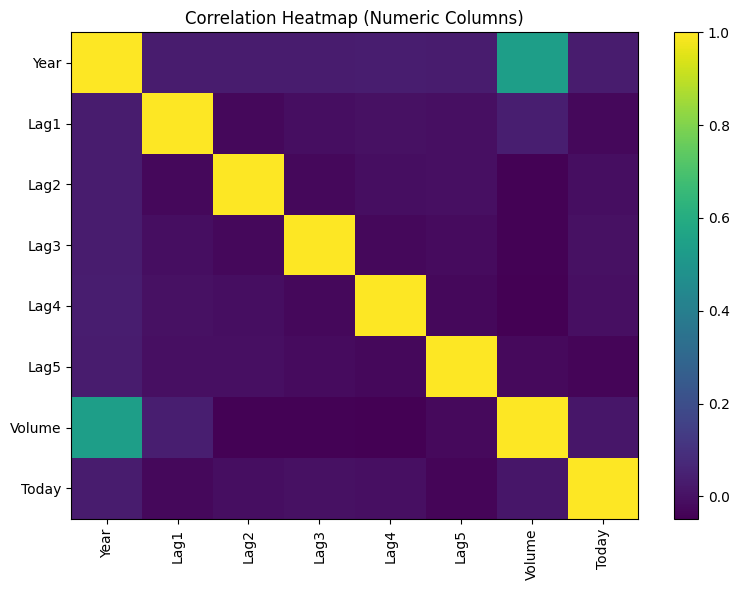

In [33]:
# Correlation matrix
predictor_correlation_matrix = numeric_columns_dataframe.corr()
print("Correlation matrix (numeric columns):\n", predictor_correlation_matrix)

matplotlib_pyplot.figure(figsize=(8, 6))
matplotlib_pyplot.imshow(predictor_correlation_matrix, aspect="auto")
matplotlib_pyplot.xticks(range(len(predictor_correlation_matrix.columns)), predictor_correlation_matrix.columns, rotation=90)
matplotlib_pyplot.yticks(range(len(predictor_correlation_matrix.index)), predictor_correlation_matrix.index)
matplotlib_pyplot.title("Correlation Heatmap (Numeric Columns)")
matplotlib_pyplot.colorbar()
matplotlib_pyplot.tight_layout()
matplotlib_pyplot.show()

## Interpretation
This correlation matrix shows that the strongest linear relationship is between Year and Volume (correlation ≈ 0.539), indicating that trading volume changes noticeably over time. The lag variables have correlations near zero with each other and with Today, which suggests very weak linear dependence among those return based predictors. This indicates that simple linear relationships among lag predictors are limited.

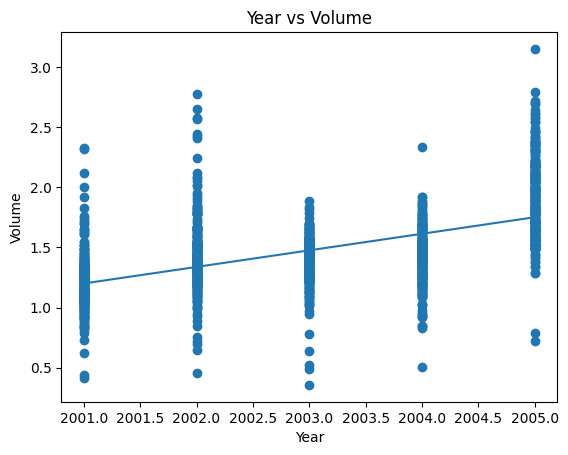

In [34]:
# Plot correlated predictors: Year vs Volume with regression line
matplotlib_pyplot.figure()
matplotlib_pyplot.scatter(smarket_dataset["Year"], smarket_dataset["Volume"])
matplotlib_pyplot.xlabel("Year")
matplotlib_pyplot.ylabel("Volume")
matplotlib_pyplot.title("Year vs Volume")

year_values = smarket_dataset["Year"].to_numpy()
volume_values = smarket_dataset["Volume"].to_numpy()
regression_coefficients = numpy.polyfit(year_values, volume_values, deg=1)
regression_line = regression_coefficients[0] * year_values + regression_coefficients[1]
matplotlib_pyplot.plot(year_values, regression_line)

matplotlib_pyplot.show()

## Interpretation
This scatter plot, together with the fitted regression line, shows an upward trend of Volume over Year. This matches the correlation result (Year–Volume ≈ 0.539) and indicates that volume tends to increase over the time period in the dataset.

In [35]:
# Logistic regression
predictor_columns_lag1_to_lag5_and_volume = ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]
predictor_matrix_lag1_to_lag5_and_volume = smarket_dataset[predictor_columns_lag1_to_lag5_and_volume]

direction_binary_response = (smarket_dataset["Direction"] == "Up").astype(int)

predictor_matrix_with_intercept_all_predictors = statsmodels_api.add_constant(
    predictor_matrix_lag1_to_lag5_and_volume,
    has_constant="add"
)

logistic_regression_model_all_predictors = statsmodels_api.Logit(
    direction_binary_response,
    predictor_matrix_with_intercept_all_predictors
).fit(disp=False)

print(logistic_regression_model_all_predictors.summary())

                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Mon, 23 Feb 2026   Pseudo R-squ.:                0.002074
Time:                        01:49:07   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.3

## Interpretation
This logistic regression model estimates how Lag1 through Lag5 and Volume relate to the probability of Direction = Up. The model fit statistics indicate weak explanatory power (pseudo R-squared ≈ 0.002074) and the likelihood-ratio test p-value is = 0.7319, showing the full model is not meaningfully stronger than an intercept-only model. This matches the coefficient table where none of the predictors stand out as statistically strong in this fit.

In [36]:
#Use logistic regression: probabilities, first 10, labels and confusion matrix
predicted_probabilities_up_all_predictors = logistic_regression_model_all_predictors.predict(
    predictor_matrix_with_intercept_all_predictors
)

print("First 10 predicted probabilities (Up):", predicted_probabilities_up_all_predictors[:10])

predicted_class_labels_all_predictors = (predicted_probabilities_up_all_predictors > 0.5).astype(int)

confusion_matrix_all_predictors = confusion_matrix(direction_binary_response, predicted_class_labels_all_predictors)
accuracy_all_predictors = accuracy_score(direction_binary_response, predicted_class_labels_all_predictors)

print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix_all_predictors)
print("Accuracy:", accuracy_all_predictors)


First 10 predicted probabilities (Up): 0    0.507084
1    0.481468
2    0.481139
3    0.515222
4    0.510781
5    0.506956
6    0.492651
7    0.509229
8    0.517614
9    0.488838
dtype: float64
Confusion matrix (rows=true, cols=pred):
 [[145 457]
 [141 507]]
Accuracy: 0.5216


## Interpretation
The first 10 predicted probabilities are all close to 0.5 (roughly in the 0.48–0.52 range), which already suggests weak separation between Up and Down. Using a 0.5 threshold gives the confusion matrix [[145, 457], [141, 507]] with accuracy = 0.5216. This includes 145 correct Down predictions and 507 correct Up predictions, but also 457 Down days predicted as Up and 141 Up days predicted as Down. This indicates the model predicts Up very frequently and makes many false Up predictions, so overall performance is only slightly above chance.

In [37]:
# Subset logistic regression "Lag1" and "Lag2"

predictor_columns_lag1_and_lag2 = ["Lag1", "Lag2"]
predictor_matrix_lag1_and_lag2 = smarket_dataset[predictor_columns_lag1_and_lag2]

predictor_matrix_with_intercept_lag1_and_lag2 = statsmodels_api.add_constant(
    predictor_matrix_lag1_and_lag2,
    has_constant="add"
)

logistic_regression_model_lag1_and_lag2 = statsmodels_api.Logit(
    direction_binary_response,
    predictor_matrix_with_intercept_lag1_and_lag2
).fit(disp=False)

print(logistic_regression_model_lag1_and_lag2.summary())

predicted_probabilities_up_lag1_and_lag2 = logistic_regression_model_lag1_and_lag2.predict(
    predictor_matrix_with_intercept_lag1_and_lag2
)

predicted_class_labels_lag1_and_lag2 = (predicted_probabilities_up_lag1_and_lag2 > 0.5).astype(int)

confusion_matrix_lag1_and_lag2 = confusion_matrix(direction_binary_response, predicted_class_labels_lag1_and_lag2)
accuracy_lag1_and_lag2 = accuracy_score(direction_binary_response, predicted_class_labels_lag1_and_lag2)

print("Confusion matrix (Lag1+Lag2):\n", confusion_matrix_lag1_and_lag2)
print("Accuracy (Lag1+Lag2):", accuracy_lag1_and_lag2)

                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1247
Method:                           MLE   Df Model:                            2
Date:                Mon, 23 Feb 2026   Pseudo R-squ.:                0.001601
Time:                        01:49:07   Log-Likelihood:                -864.20
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.2502
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0742      0.057      1.310      0.190      -0.037       0.185
Lag1          -0.0715      0.050     -1.427      0.153      -0.170       0.027
Lag2          -0.0445      0.050     -0.890      0.3

## Interpretation
This reduced logistic regression uses only Lag1 and Lag2. The fit statistics remain weak (pseudo R-squared ≈ 0.001601 and LLR p-value = 0.2502), and the classification results are confusion matrix [[114, 488], [102, 546]] with accuracy = 0.528. This is a small improvement over 0.5216, but the model still predicts Up heavily (488 + 546 predictions of Up) and misclassifies many Down days as Up. This indicates that restricting to Lag1 and Lag2 does not create strong predictive separation, even though it slightly improves accuracy.

In [38]:
# Perform LDA and print LDA details

linear_discriminant_analysis_model_lag1_and_lag2 = LinearDiscriminantAnalysis()
linear_discriminant_analysis_model_lag1_and_lag2.fit(predictor_matrix_lag1_and_lag2, direction_binary_response)

print("LDA class priors:", linear_discriminant_analysis_model_lag1_and_lag2.priors_)
print("LDA class means (rows=classes, cols=Lag1,Lag2):\n", linear_discriminant_analysis_model_lag1_and_lag2.means_)
print("LDA coefficients:\n", linear_discriminant_analysis_model_lag1_and_lag2.coef_)

LDA class priors: [0.4816 0.5184]
LDA class means (rows=classes, cols=Lag1,Lag2):
 [[ 0.05068605  0.03229734]
 [-0.03969136 -0.02244444]]
LDA coefficients:
 [[-0.07126095 -0.04433204]]


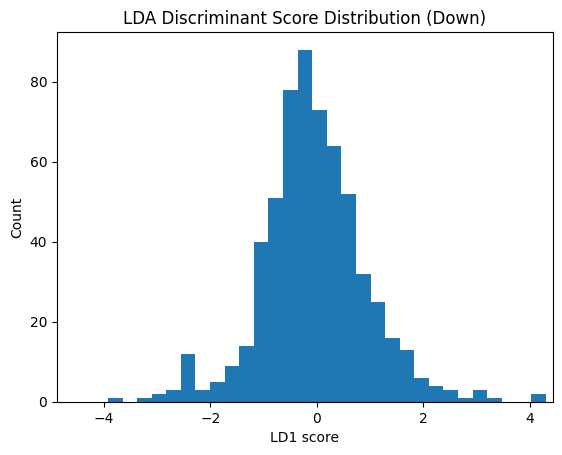

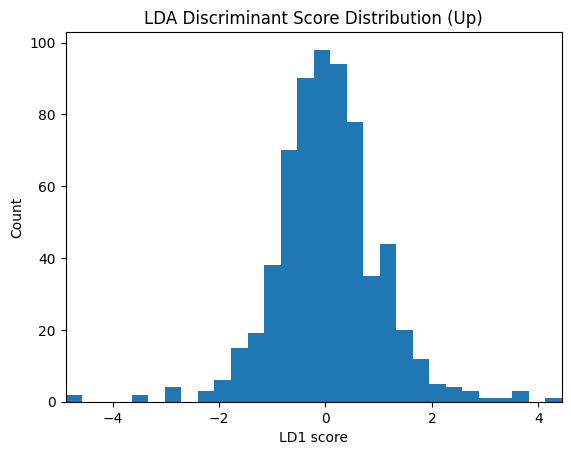

In [39]:
# LDA Plot

lda_discriminant_scores = linear_discriminant_analysis_model_lag1_and_lag2.transform(
    predictor_matrix_lag1_and_lag2
).ravel()

lda_scores_down = lda_discriminant_scores[direction_binary_response == 0]
lda_scores_up = lda_discriminant_scores[direction_binary_response == 1]

# Use the same x-limits for both plots (so the comparison is fair)
common_minimum_score = float(numpy.min(lda_discriminant_scores))
common_maximum_score = float(numpy.max(lda_discriminant_scores))

matplotlib_pyplot.figure()
matplotlib_pyplot.hist(lda_scores_down, bins=30)
matplotlib_pyplot.xlim(common_minimum_score, common_maximum_score)
matplotlib_pyplot.title("LDA Discriminant Score Distribution (Down)")
matplotlib_pyplot.xlabel("LD1 score")
matplotlib_pyplot.ylabel("Count")
matplotlib_pyplot.show()

matplotlib_pyplot.figure()
matplotlib_pyplot.hist(lda_scores_up, bins=30)
matplotlib_pyplot.xlim(common_minimum_score, common_maximum_score)
matplotlib_pyplot.title("LDA Discriminant Score Distribution (Up)")
matplotlib_pyplot.xlabel("LD1 score")
matplotlib_pyplot.ylabel("Count")
matplotlib_pyplot.show()

In [40]:
# Use LDA "confusion matrix and accuracy"
predicted_class_labels_lda = linear_discriminant_analysis_model_lag1_and_lag2.predict(predictor_matrix_lag1_and_lag2)

confusion_matrix_lda = confusion_matrix(direction_binary_response, predicted_class_labels_lda)
accuracy_lda = accuracy_score(direction_binary_response, predicted_class_labels_lda)

print("LDA confusion matrix:\n", confusion_matrix_lda)
print("LDA accuracy:", accuracy_lda)

LDA confusion matrix:
 [[114 488]
 [102 546]]
LDA accuracy: 0.528


## Interpretation
This LDA model uses Lag1 and Lag2 with class priors [0.4816, 0.5184] (Down, Up). The class means are close to zero (Down: [0.0507, 0.0323], Up: [-0.0397, -0.0224]) and the coefficients are [-0.0713, -0.0443], which indicates only a small shift between classes along the linear discriminant direction. The confusion matrix is [[114, 488], [102, 546]] and the accuracy is 0.528, which matches the reduced logistic regression result. The separated LDA histograms show substantial overlap between Down and Up LD1 scores, which explains why classification accuracy remains close to 0.5.

In [41]:
# Perform QDA and print QDA means/priors

quadratic_discriminant_analysis_model_lag1_and_lag2 = QuadraticDiscriminantAnalysis()
quadratic_discriminant_analysis_model_lag1_and_lag2.fit(predictor_matrix_lag1_and_lag2, direction_binary_response)

print("QDA class priors:", quadratic_discriminant_analysis_model_lag1_and_lag2.priors_)
print("QDA class means (rows=classes, cols=Lag1,Lag2):\n", quadratic_discriminant_analysis_model_lag1_and_lag2.means_)

QDA class priors: [0.4816 0.5184]
QDA class means (rows=classes, cols=Lag1,Lag2):
 [[ 0.05068605  0.03229734]
 [-0.03969136 -0.02244444]]


In [42]:
# Use QDA "confusion matrix and accuracy

predicted_class_labels_qda = quadratic_discriminant_analysis_model_lag1_and_lag2.predict(predictor_matrix_lag1_and_lag2)

confusion_matrix_qda = confusion_matrix(direction_binary_response, predicted_class_labels_qda)
accuracy_qda = accuracy_score(direction_binary_response, predicted_class_labels_qda)

print("QDA confusion matrix:\n", confusion_matrix_qda)
print("QDA accuracy:", accuracy_qda)

QDA confusion matrix:
 [[109 493]
 [ 94 554]]
QDA accuracy: 0.5304


## Interpretation
This QDA model allows different covariance estimates for each class while still using Lag1 and Lag2. The confusion matrix is [[109, 493], [94, 554]] with accuracy = 0.5304. Compared with LDA accuracy 0.528, QDA improves accuracy by 0.0024, which is a very small gain. The matrix also shows 493 Down days predicted as Up, so misclassification of Down remains the dominant error. This indicates that the additional flexibility of QDA provides only a minor improvement for these predictors.

In [43]:
training_rows_mask_year_less_than_2005 = smarket_dataset["Year"] < 2005

training_predictors_lag1_and_lag2 = smarket_dataset.loc[training_rows_mask_year_less_than_2005, ["Lag1", "Lag2"]]
training_direction_binary_response = direction_binary_response.loc[training_rows_mask_year_less_than_2005]

testing_predictors_lag1_and_lag2 = smarket_dataset.loc[~training_rows_mask_year_less_than_2005, ["Lag1", "Lag2"]]
testing_direction_binary_response = direction_binary_response.loc[~training_rows_mask_year_less_than_2005]

standard_scaler_for_knn = StandardScaler()
training_predictors_scaled = standard_scaler_for_knn.fit_transform(training_predictors_lag1_and_lag2)
testing_predictors_scaled = standard_scaler_for_knn.transform(testing_predictors_lag1_and_lag2)

for number_of_neighbors in [1, 3]:
    knn_classifier_model = KNeighborsClassifier(n_neighbors=number_of_neighbors)
    knn_classifier_model.fit(training_predictors_scaled, training_direction_binary_response)

    predicted_testing_class_labels = knn_classifier_model.predict(testing_predictors_scaled)

    confusion_matrix_knn = confusion_matrix(testing_direction_binary_response, predicted_testing_class_labels)
    accuracy_knn = accuracy_score(testing_direction_binary_response, predicted_testing_class_labels)

    print("\nk-NN with k =", number_of_neighbors)
    print("Confusion matrix:\n", confusion_matrix_knn)
    print("Accuracy:", accuracy_knn)


k-NN with k = 1
Confusion matrix:
 [[43 68]
 [58 83]]
Accuracy: 0.5

k-NN with k = 3
Confusion matrix:
 [[48 63]
 [55 86]]
Accuracy: 0.5317460317460317


## Interpretation
This evaluates k-NN using a time-based split: training on Year < 2005 and testing on Year == 2005. For k = 1, the confusion matrix [[43, 68], [58, 83]] gives accuracy = 0.50, which is essentially chance on the test set. For k = 3, the confusion matrix [[48, 63], [55, 86]] gives accuracy ≈ 0.5317, which is an improvement of about 0.0317 over k = 1. This indicates that using a slightly larger neighborhood reduces sensitivity to single neighbors, but overall predictive performance remains modest on the 2005 test data.

In [44]:
# Champion selection 

knn_accuracy_k_equals_1 = 0.50
knn_accuracy_k_equals_3 = 0.5317

champion_model_name = "k-NN (k = 3)"
champion_accuracy_value = knn_accuracy_k_equals_3

print("Candidate accuracies:")
print("k-NN (k = 1) test accuracy:", knn_accuracy_k_equals_1)
print("k-NN (k = 3) test accuracy:", knn_accuracy_k_equals_3)

print("\nChampion model:", champion_model_name)
print("Champion accuracy:", champion_accuracy_value)

Candidate accuracies:
k-NN (k = 1) test accuracy: 0.5
k-NN (k = 3) test accuracy: 0.5317

Champion model: k-NN (k = 3)
Champion accuracy: 0.5317


## Champion and why this was maybe expected
The champion is k-NN with k = 3 because it has the highest accuracy on the held-out 2005 test set (accuracy = 0.5317). k = 1 achieves accuracy = 0.50, which is essentially chance. Using k = 3 is less sensitive to a single nearest neighbor and therefore produces a more stable decision compared with k = 1. The improvement is still small, which indicates that Lag1 and Lag2 provide limited predictive separation for Direction on the 2005 test data.